In [1]:
%cd /home/andre/PycharmProjects/geonumerics/source/python/Forex
import RF_Forex as rfforex
import Forex_Real_Time
from Pattern_Analysis import PreparePredictionData

/home/andre/PycharmProjects/geonumerics/source/python/Forex


/home/andre/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from matplotlib import pyplot
%pylab inline
import urllib.request
import re
import pandas as pd
import datetime
import time
import seaborn as sns
from scipy import stats
from matplotlib import dates

Populating the interactive namespace from numpy and matplotlib


### Read the dataframe being created by the other notebook ###

In [6]:
%cd /home/andre/PycharmProjects/geonumerics/stock_data/

/home/andre/PycharmProjects/geonumerics/stock_data


In [54]:
dfdata = pd.read_pickle('real_time_quotes_13_06_to_23_06.pandas')

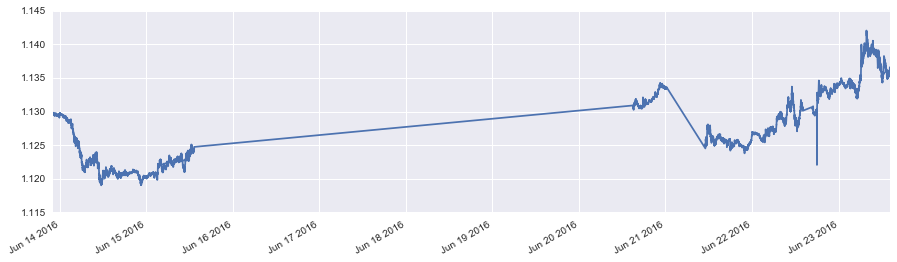

In [55]:
dfdata['EUR/USD'].plot(figsize=(15,4))

In [56]:
dfdata.index[0]

Timestamp('2016-06-13 22:11:06.188114')

In [57]:
#%%time

#try:
#    dfdata = pd.read_pickle('real_time_quotes.pandas')
#    dfdata = dfdata.set_index(pd.DatetimeIndex(dfdata['time']))
#    dfdata.drop('time', axis='columns', inplace=True) #not needed anymore
#except:
#    pass

print(len(dfdata[::2]))

5262


### RANDOM TARGET VARIABLE ###

### QUICK ANALYSIS OF ALL DATA ###

In [47]:
#targeti = np.random.randint(0, len(dfdata.columns))
#target_quote = 'AUD/USD' # TARGET VARIABLE
#target_quote = 'EUR/AUD' # TARGET VARIABLE
#target_quote = 'EUR/USD' # TARGET VARIABLE
target_quote = 'GBP/USD' # TARGET VARIABLE
#target_quote = 'USD/CAD' # TARGET VARIABLE
#target_quote = 'USD/NOK' # TARGET VARIABLE
#target_quote = 'AUD/JPY' # TARGET VARIABLE
#target_quote = dfdata.columns[targeti]
print(target_quote)

GBP/USD


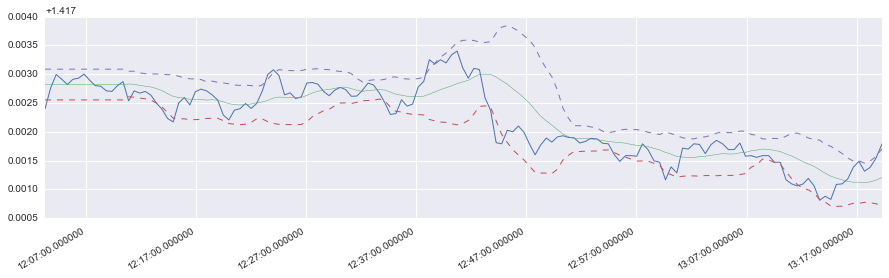

In [48]:
plt.figure(figsize=(15,4))
# bollinger bands
sd = dfdata[target_quote]
sd = sd[-150:]
sdsm = sd.rolling(15).mean()
sdsm.fillna(method='bfill', inplace=True) # fix problem with not enough data on moving average
std = sd.rolling(15).std()
std.fillna(method='bfill', inplace=True) # fix problem with not enough data on moving average
sdmi = sdsm - 1.8*std
sdma = sdsm + 1.8*std
sd.plot(lw=1)
sdsm.plot(lw=0.5)
sdmi.plot(style='--', lw=1)
sdma.plot(style='--', lw=1)

zig zag times << 1% 5% 10% 45% 50% 99% 
[  1.08   1.36   1.73   5.09   5.74  32.42]
90 percent data trends with length P90 > 1.73 minutes
number of samples shifted  4
shift 240.0 (seconds)


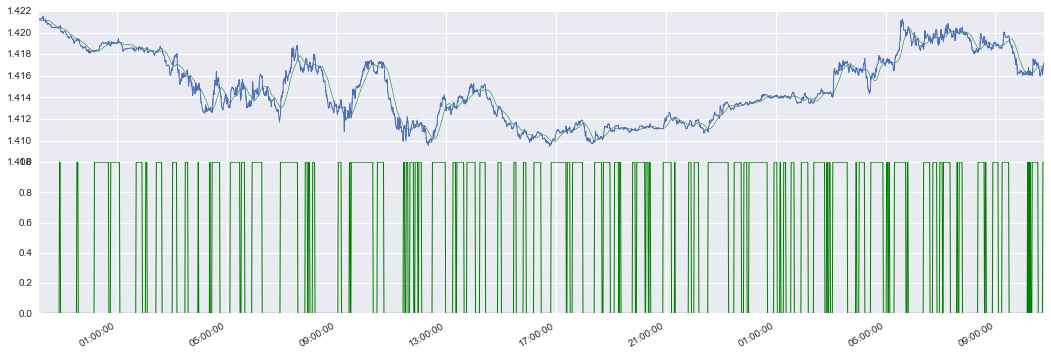

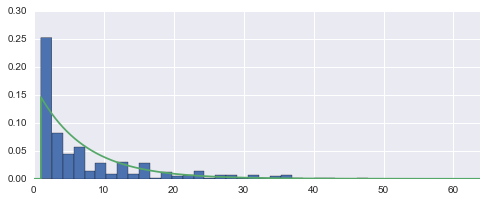

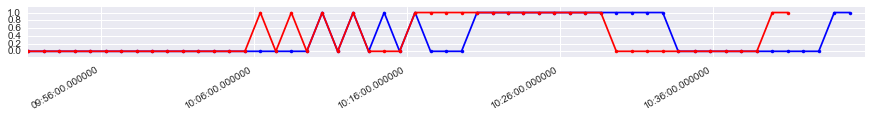

In [285]:
cp  = dfdata[:-300:2] # 30 or 60 seconds
cp = cp.copy() # avoid stupid warning from pandas
#cp = cp.ewm(span=6).mean() # média de 1 minuto
pp = PreparePredictionData(cp, target_quote, dt=60)
#pp.viewquote()
pp.create_binary_zig_zag_class_sm(20, smooth=3)
pp.make_shifted_binary_zig_zag_class()

In [259]:
pp.create_indicatores()
pp.normalize()
pp.calculate_corr_and_remove()
Xtrain, ytrain, Xpredict = pp.prepare_training()

rsi_20 EUR/GBP       0.402157
rsi_30 EUR/GBP       0.393039
rsi_10 EUR/GBP       0.393039
dema_15 EUR/GBP      0.377966
macd_tiny EUR/GBP    0.373628
Name: target_variable_dup, dtype: float64
ema_2 AUD/JPY          0.006972
ema_10 GBP/JPY         0.005044
macd_double USD/CHF    0.004367
ema_3 AUD/JPY          0.002008
macd_double AUD/JPY    0.000562
Name: target_variable_dup, dtype: float64


In [260]:
#pp.dfquotes.ne
#Xtrain.head(10)

In [50]:
class classifier_training:
    def __init__(self):
        pass
        
    def quickLookAnalysisTraining(self, X, y, shift, windown=60, nanalysis=-1):
        self.shift = shift
        self.windown = windown        
        accuracies, model = rfforex.performQuickTrainigAnalysis(X, y, shift, 
                                                                windown=windown, nanalysis=nanalysis)
        self.model = model
        self.accuracies = accuracies
        print("mean accuracy %", 100*np.mean(self.accuracies[1]))
    
    def viewquickLookAnalysis(self, time_index_training):
        
        accuracies_index = np.array([time_index_training[i] for i in self.accuracies[0]])
        pdaccuracies = pd.DataFrame(self.accuracies[1], columns=['accuracy'],
                        index=accuracies_index)
        fig, axr = pyplot.subplots(1, sharex=True, figsize=(15,4))
        # average 8
        pdaccuracies['mean'] = pdaccuracies.accuracy.ewm(span=8).mean()
        pdaccuracies['perc45'] = pd.Series(np.ones(self.accuracies[1].size)*0.6897, index=pdaccuracies.index) # 45%
        pdaccuracies['perc70'] = pd.Series(np.ones(self.accuracies[1].size)*0.5882, index=pdaccuracies.index) # 70%
        pdaccuracies['perc80'] = pd.Series(np.ones(self.accuracies[1].size)*0.5556, index=pdaccuracies.index) # 80%
        pdaccuracies.plot(ax=axr, ylim=(-0.5, 1.5), 
                          style=['ok--', 'b-', '--g', '--g', '--r'], xticks=accuracies_index) 
        date_fmt = '%H:%M:%S'
        formatter = dates.DateFormatter(date_fmt)
        axr.xaxis.set_major_formatter(formatter)
        plt.gcf().autofmt_xdate()
        
    def windowAnalysis(self, X, y, shift, windowgenerator, nanalysis=15):
        
        all_accuracies = []        
        for window in windowgenerator:
            self.quickLookAnalysisTraining(X, y, shift, window, nanalysis=nanalysis)            
            all_accuracies.append(np.mean(100*np.mean(self.accuracies[1])))        
        plt.plot(windowgenerator, all_accuracies, 'o-')        
            
    def Predict(self, X):
        return self.model.predict(X)

In [262]:
#ytrain

In [263]:
#%%timeit -n 3 -r 1
#60, 120, 240, 480
#70%, 85%, 68%, 82%
#64%, 63%, 61%, 76%
# number of samples used in each training makes a lot of difference (window parameter)
# warm_start=True is complicated got need to study how to increase number of features
# to see if it is worthwhile 
# Can not do continues training, one tree each time FOR NOW

classifier = classifier_training()
classifier.quickLookAnalysisTraining(Xtrain, ytrain, pp.shift, 150, 18)

Size train set:  (2269, 183)
samples in each window:  150
number of analysis:  18
percent of data used  95.01983252534157
mean accuracy % 88.8888888889


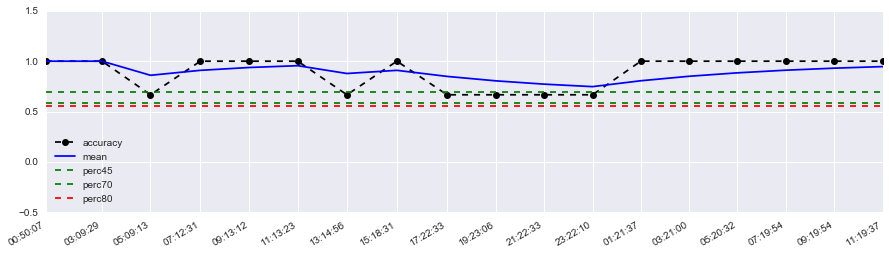

In [264]:
classifier.viewquickLookAnalysis(pp.time_index_training)

In [209]:
print(pp.last_time_training)

2016-06-15 00:29:01.572656


### Create special window do validate training and see if it will go up  or down ###

1. Use the last samples to visually see if it is still predicting correctly
2. Plot over or among the original price chart the predictions

In [228]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def see_prediction(serie_target, average_delta, serie_pivots, serie_du,
                   clfmodel, data2predict, shift, dt):
    # plot the last samples corresponding to 5 mean zig zag values
    nsee=7
    fig, axr = plt.subplots(2, sharex=True, figsize=(18, 5))
    average_delta = pd.Timedelta(average_delta, unit='s') # FROM sampling rate in seconds
    serie_target[ serie_target.index > (serie_target.index[-1] - average_delta*nsee) ].plot(ax=axr[0])
    selection = serie_pivots[ serie_pivots.index > (serie_pivots.index[-1] - average_delta*nsee) ]
    serie_target[selection.index].plot(ax=axr[0], style='ok--')
    serie_du[serie_du.index > (serie_du.index[-1] - average_delta*nsee)].plot(ax=axr[1], style='.k')
    # prediction        
    # original position of the predictor sample
    serie_prediction_orig = pd.Series(np.ones(data2predict.index.size)*0.5, 
                                      index=serie_target.index[data2predict.index]) 
    serie_prediction_orig.plot(ax=axr[1], style='.g')
    
    # those are predictions need to have the corresponding shift in time
    fst_predict_time = serie_target.index[data2predict.index[0]]+dt*shift
    serie_prediction = pd.Series(clfmodel.predict(data2predict), 
                                 index=pd.date_range(fst_predict_time, 
                                                     periods=data2predict.index.size, freq=dt))
    # format x axis tick labels
    all_ticks = serie_prediction.index.union(selection.index)[::1]
    serie_prediction.plot(ax=axr[1], style='.g-', xticks=all_ticks)
    date_fmt = '%H:%M:%S'
    formatter = dates.DateFormatter(date_fmt)
    axr[1].xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    #print(serie_prediction.values)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)

2016-06-15 13:18:44.019330


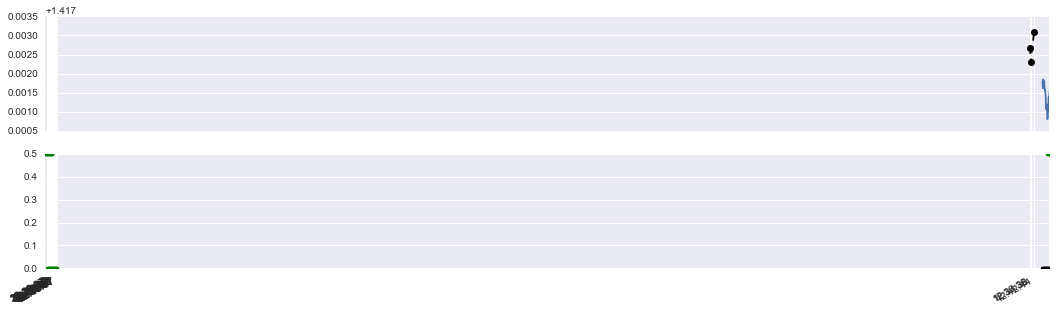

In [229]:
see_prediction(pp.srtarget, pp.percentiles[2]*60., pp.srpivots, pp.srdu,
               classifier.model, pp.topredict, pp.shift, pp.dt)

print(pp.last_time_real)

In [186]:
# vou criando amostras de 15 em 15
###  treinando de 60 em 60  bla bla bla bla
# predizendo de 15 em 15 e apostando
# só posso comprar na prática 1 minutos depois da última amostra
# vamos apostar no turbo 2 minutos de duração

# remover todas prediçoes menores que 5%

# vou apostar em quantos minutos?
# fitar variações de preço baseado na aposta que quero fazer.
# se for turbo 1, 2, 3, 4 e 5 minutos
# binary 15, 30, 60, 90, 120, 180, 240 etc minutos

In [51]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def iqoption_strategy_tester(dfdata, target_quote, train_size, shift, 
                             estimators=800, span=20, dt=60, plot=False):
    
    iqbuy = [] # store strategy results
    data = dfdata.copy()    

    pshifts = round(data.index.size-train_size+1-shift) # possible shifts N-train_size+1
    if plot:
        print('number of input samples {}'.format(pshifts))
        pbar = FloatProgress(min=0, max=pshifts)
        display(pbar)

    # sliding window with 1 minute
    # Input data one sample each time
    for i in range(0, pshifts-1, 1): # shift, classify and cross-validate
        if plot:
            pbar.value = i # counter of analysis

        inner_data = data[:i+train_size] 
        inner_data = inner_data.copy() # avoid stupid warning from pandas
        pp = PreparePredictionData(inner_data, target_quote, dt) 
        pp.create_binary_zig_zag_class_sm(span, smooth=3, plot=False)
        pp.make_shifted_binary_zig_zag_class(shift=shift, plot=False)
        if inner_data.index[-2] in pp.srpivots.index: # it is a crossing so we can predict/buy
            pp.create_indicatores()
            pp.normalize()
            pp.calculate_corr_and_remove(verbose=False)
            # can only be identified 2 samples after
            Xtrain, ytrain, Xpredict = pp.prepare_training()
            clfmodel = ExtraTreesClassifier(n_estimators=estimators, 
                                            n_jobs=-1, bootstrap=True, oob_score=True, verbose=0)    
            clfmodel.fit(Xtrain.tail(train_size), ytrain.tail(train_size))
            prediction = clfmodel.predict(pp.topredict)
            # + 1 minute = 1 samples
            # buy time value index median
            # end time value index 2 minutes = 12 samples
            iqbuy.append({"buyindex": pp.topredict.index[-1]+1, 
                          "updown" : np.median(prediction[1:]), 
                          "endindex" : pp.topredict.index[-1]+pp.shift+1,
                          "error" : clfmodel.oob_score_
                         })
        del inner_data

    iqdf = pd.DataFrame(iqbuy)
    
    if len(iqbuy) == 0:
        return 0, 3.141592654, iqdf 
    
    iqdf['buyvalue'] = data.ix[iqdf['buyindex'], target_quote].values # value of buying
    iqdf['endvalue'] = data.ix[iqdf['endindex'], target_quote].values # final value after bet binary
    iqdf.drop(iqdf[ (iqdf['endvalue'] == iqdf['buyvalue'])  ].index , axis=0, inplace=True) # no win no loss
    iqdf['realup'] = iqdf['endvalue'] - iqdf['buyvalue']
    iqdf['bup'] = iqdf['realup'].apply(lambda x: 1 if x > 0 else 0)
    #iqdf['bup'] = iqdf['realup'].apply(lambda x: np.nan if x == 0)
    iqdf['right'] = (iqdf['bup'] == iqdf['updown'])
    iqdf['cum'] = iqdf['right'].apply(lambda x: 1 if x==True else -1)
    mean_accuracy = ((iqdf[iqdf['right'] == True].index.size)/iqdf.index.size)
    iqdf['cum'] = iqdf['right'].apply(lambda x: 1 if x==True else 0)
    iqdf['cum'] = iqdf['cum'].cumsum()/(iqdf.index+1)
    std_accuracy = iqdf['cum'].std()
    if plot:
        print('mean accuray is {} +/- {}'.format(mean_accuracy, 2.5*std_accuracy/np.sqrt(len(iqdf)))) 
        # 2.5 == 95%
        iqdf['cum'].plot(style='*r--', lw=0.5, figsize=(15,2))
        plt.figure()
        iqdf['error'].plot(lw=0.5, figsize=(15,2))

    return mean_accuracy, std_accuracy, iqdf

number of input samples 1670
mean accuray is 0.4524590163934426 +/- 0.06111689143360972


,buyindex,endindex,error,updown,buyvalue,endvalue,realup,bup,right,cum
0,603,613,0.842373,0.0,1.413405,1.413235,-0.000170,0,True,1.000000
1,604,614,0.849408,0.0,1.413130,1.413365,0.000235,1,False,0.500000
2,611,621,0.861204,0.0,1.413180,1.412990,-0.000190,0,True,0.666667
3,616,626,0.860000,0.0,1.412420,1.413040,0.000620,1,False,0.500000
4,620,630,0.858333,0.0,1.413130,1.412630,-0.000500,0,True,0.600000
5,627,637,0.850000,1.0,1.412810,1.412145,-0.000665,0,False,0.500000
6,633,643,0.840000,0.0,1.412875,1.413485,0.000610,1,False,0.428571
7,635,645,0.838333,0.0,1.412010,1.412285,0.000275,1,False,0.375000
8,640,650,0.841667,0.0,1.412080,1.414655,0.002575,1,False,0.333333
9,641,651,0.838333,0.0,1.412080,1.414215,0.002135,1,False,0.300000


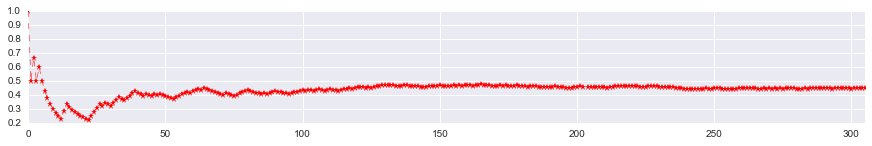

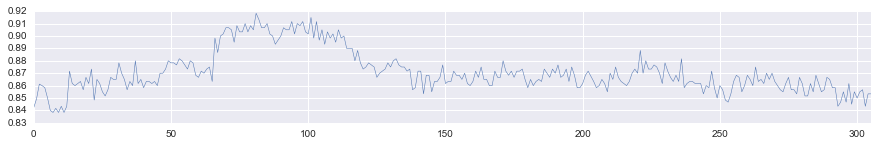

In [52]:
result = iqoption_strategy_tester(dfdata[::2], target_quote, 500, 10, span=10, plot=True)


In [140]:
#dfaccuracy
#x['accuracy']

In [143]:
x['accuracy'] = x['right'].apply(lambda x: 1 if x else 0)
x['index'] = dfdata.ix[x['buyindex']].index # get original time index for the buying time
dfaccuracy = x.set_index('index')

In [148]:
#dfaccuracy

### Create class of regions where the prediction worked acceptable ###

use median filters for that

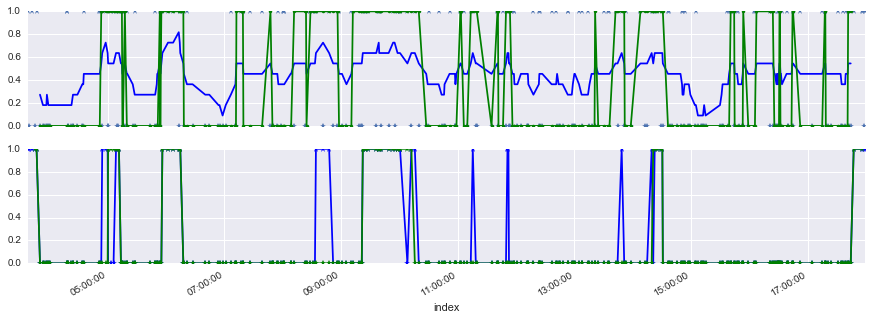

In [198]:
fig, axr = plt.subplots(2, sharex=True, figsize=(15,5))
dfaccuracy.accuracy.plot(style='*', figsize=(15,5), ax=axr[0])
#plt.subplots_adjust()
dfaccuracy['accuracy_mean'] = dfaccuracy.accuracy.rolling(11).mean(center=True)
dfaccuracy['accuracy_mean'].plot(style='b-', ax=axr[0])
dfaccuracy['accuracy_class'] = dfaccuracy.accuracy.rolling(11).median(center=True)
dfaccuracy['accuracy_class'].plot(style='.g-', ax=axr[0])
dfaccuracy['accuracy_class4'] = dfaccuracy['accuracy_mean'].apply(lambda x: 0 if x < 0.6 else 1.)
dfaccuracy['accuracy_class4'].plot(style='*b-', ax=axr[1])
dfaccuracy['accuracy_class5'] = dfaccuracy['accuracy_class4'].rolling(7).median(center=True)
dfaccuracy['accuracy_class5'].plot(style='*g-', ax=axr[1])

#x['cum'].plot()


(-0.5, 1.5)

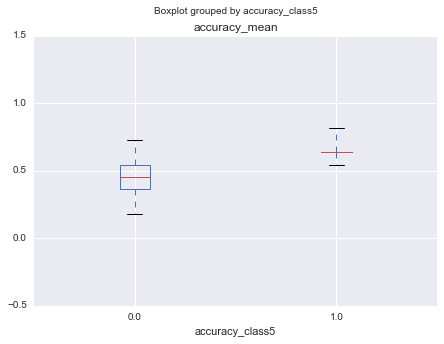

In [199]:
dfaccuracy.boxplot('accuracy_mean', by='accuracy_class5', figsize=(7,5))
plt.ylim(-0.5, 1.5)

In [228]:
dfdata[::2].index.size

2279

In [230]:
%%time
import itertools

# testing on one minute
trainsize = np.arange(150, 551, 100)
shift = np.arange(2, 11, 2)
estimators = np.arange(100, 2001, 200)
span = np.arange(10, 21, 10)
paramcombinations = list(itertools.product(*[trainsize, shift, estimators, span]))
comb_params = pd.DataFrame(paramcombinations, columns=['train_size', 'shift', 'estimators', 'span'])
params = comb_params.to_dict('records')

nanalysis = 200 # nuumber of analysis (samples inputed) even though crossings are defined by span 
# indirectly
vs = []
for i, param in enumerate(params):
#    iqoption_strategy_tester(dfdata, target_quote, train_size, shift, 
#                         estimators=800, span=20, dt=60, plot=False)
    #i=241
    #param = params[i]
    datasize = nanalysis+param['train_size']+param['shift']+1
    result = iqoption_strategy_tester(dfdata[::2][600:600+datasize], target_quote, **param)
    #v = np.array(result[:2]) # mean and std
    #v[1] = 1-v[1] # convert std to 1 scale the bigger the better
    #v = np.sqrt(np.vdot(v, v))
    vs.append((result[:2], len(result[2])))    
    print(i)
    #break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
#dfresult = pd.DataFrame(params) 
#dfresult['accuracy'] = np.array([vs[i][0][0] for i in range(len(vs))])
#dfresult['std'] = np.array([vs[i][0][1] for i in range(len(vs))])
#dfresult['n'] = np.array([vs[i][1] for i in range(len(vs))])

In [7]:
#dfresult['accuracy'] = np.array([vs[i][0][0] for i in range(len(vs))])
#dfresult['std'] = np.array([vs[i][0][1] for i in range(len(vs))])
#dfresult['n'] = np.array([vs[i][1] for i in range(len(vs))])
#dfresult = dfresult.drop(dfresult.loc[dfresult['n']==1].index)

In [9]:
#dfresult.to_pickle('500_tests_params.pandas')

In [5]:
dfresult = pd.read_pickle('500_tests_params.pandas')

In [6]:
dfresult.head(4)

,estimators,shift,span,train_size,accuracy,std,n
0,100,2,10,150,0.450000,0.136456,40
1,100,2,20,150,0.423077,0.155571,26
2,300,2,10,150,0.500000,0.117828,40
3,300,2,20,150,0.307692,0.102425,26


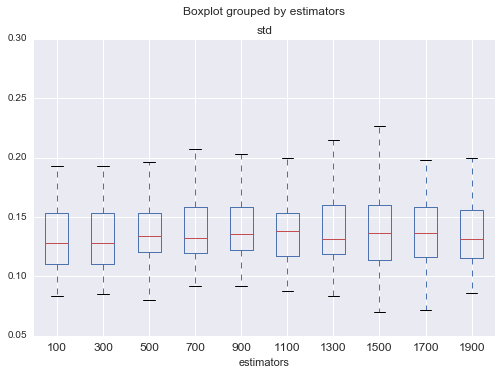

In [37]:
dfresult.boxplot('std', by='estimators')

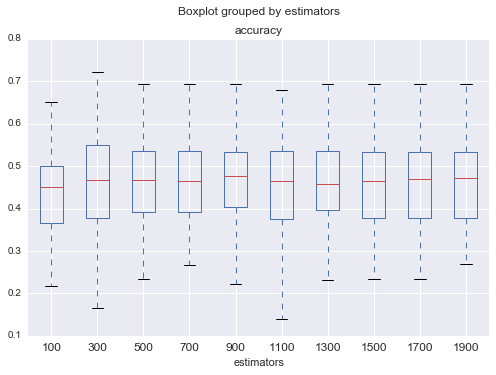

In [38]:
#dfresult[ (dfresult['estimators'] > 500) & (dfresult['span'] == 20)].boxplot('accuracy', by='estimators')
dfresult.boxplot('accuracy', by='estimators')

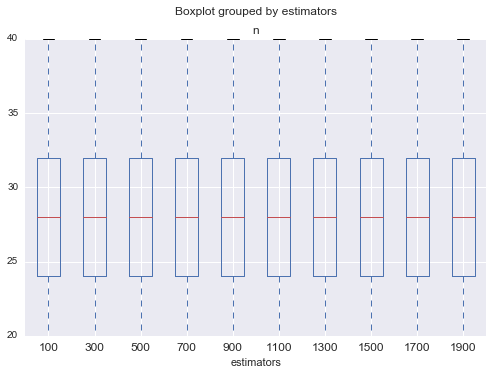

In [39]:
dfresult.boxplot('n', by='estimators')

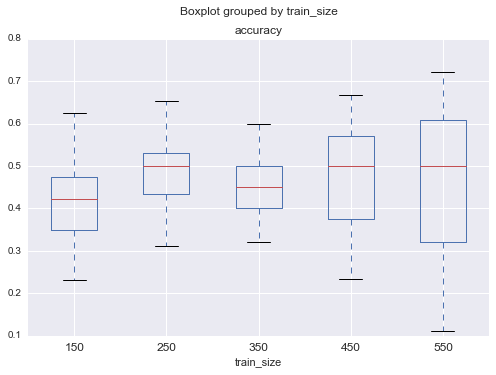

In [40]:
dfresult.boxplot('accuracy', by='train_size')

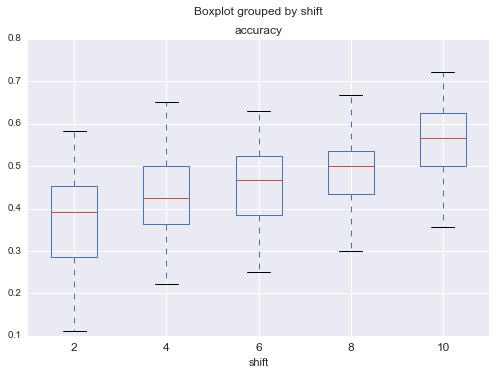

In [41]:
dfresult.boxplot('accuracy', by='shift')

In [45]:
dfresult.sort_values(by='accuracy', ascending=False)

,estimators,shift,span,train_size,accuracy,std,n
482,300,10,10,550,0.722222,0.169238,36
498,1900,10,10,550,0.694444,0.161026,36
496,1700,10,10,550,0.694444,0.161026,36
484,500,10,10,550,0.694444,0.160557,36
494,1500,10,10,550,0.694444,0.161026,36
486,700,10,10,550,0.694444,0.161026,36
492,1300,10,10,550,0.694444,0.161026,36
488,900,10,10,550,0.694444,0.160557,36
499,1900,10,20,550,0.678571,0.127534,28
489,900,10,20,550,0.678571,0.127534,28


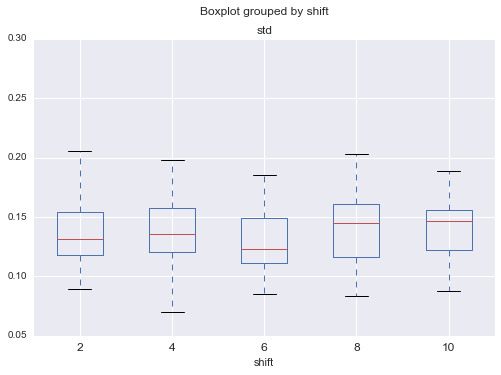

In [42]:
dfresult.boxplot('std', by='shift')

In [8]:
dfsorted = dfresult.sort_values(by='estimators')

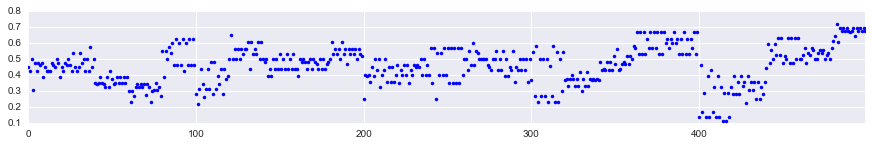

In [9]:
dfsorted.accuracy.plot(style='.b', lw=0.5, figsize=(15,2))

In [276]:
dfsorted[300:400].head(5)

,estimators,shift,span,train_size,accuracy,std,n
112,1300,2,10,250,0.312500,0.125112,32
373,1300,8,20,450,0.666667,0.096409,24
393,1300,10,20,450,0.625000,0.104029,24
392,1300,10,10,450,0.533333,0.117640,30
472,1300,8,10,550,0.555556,0.153162,36


In [275]:
dfsorted[300:400].tail(5)

,estimators,shift,span,train_size,accuracy,std,n
354,1500,6,10,450,0.466667,0.148915,30
475,1500,8,20,550,0.500000,0.163232,28
135,1500,4,20,250,0.565217,0.140791,23
454,1500,6,10,550,0.472222,0.127227,36
214,1500,2,10,350,0.357143,0.101421,28


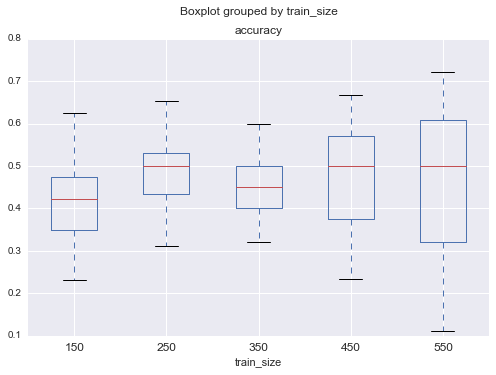

In [23]:
dfsorted.boxplot(['accuracy'], by='train_size')

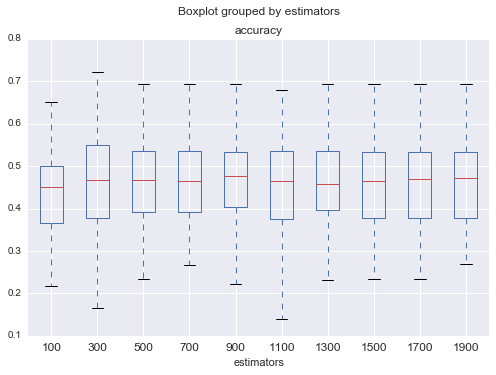

In [22]:
dfsorted.boxplot(['accuracy'], by='estimators')

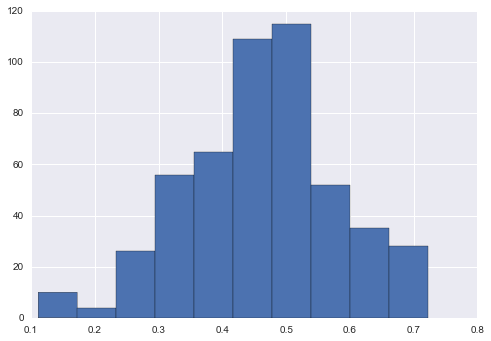

In [278]:
dfsorted.accuracy.hist()

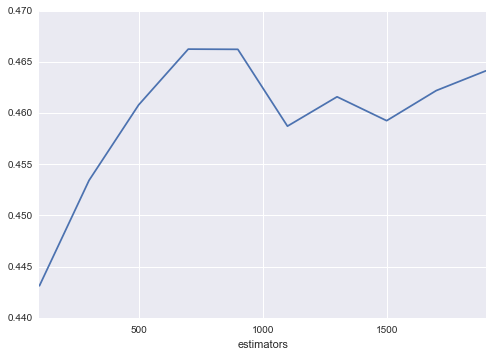

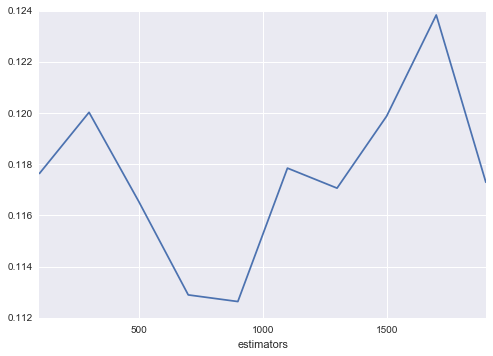

In [17]:
estimatorsgroup = dfsorted.groupby(by='estimators')
stdx = estimatorsgroup.std()
meanx = estimatorsgroup.mean()
meanx.accuracy.plot()
plt.figure()
stdx.accuracy.plot()

In [244]:
estimatorsgroup.estimators.unique()

estimators
100      [100]
300      [300]
500      [500]
700      [700]
900      [900]
1100    [1100]
1300    [1300]
1500    [1500]
1700    [1700]
1900    [1900]
Name: estimators, dtype: object

In [257]:
estimatorsgroup.groups[1700]


[217,
 236,
 36,
 37,
 57,
 196,
 456,
 457,
 237,
 197,
 497,
 257,
 256,
 496,
 216,
 276,
 436,
 437,
 56,
 277,
 116,
 176,
 117,
 357,
 356,
 376,
 377,
 476,
 97,
 96,
 477,
 337,
 336,
 177,
 136,
 137,
 296,
 17,
 16,
 417,
 396,
 397,
 416,
 317,
 316,
 77,
 297,
 157,
 76,
 156]